# ESRGAN using tensorflow

Why ESRGAN and not SRGAN ? 

Paper : https://arxiv.org/pdf/1809.00219

The Super-Resolution Generative Adversarial Network (SRGAN) is a seminal work that is capable of generating realistic textures during single image super-resolution. However, the hallucinated details are often accompanied with unpleasant artifacts. To further enhance the
visual quality, we thoroughly study three key components of SRGAN – network architecture, adversarial loss and perceptual loss, and improve each of them to derive an Enhanced SRGAN (ESRGAN). In particular, we introduce the Residual-in-Residual Dense Block (RRDB) without batch normalization as the basic network building unit. Moreover, we
borrow the idea from relativistic GAN [2] to let the discriminator predict relative realness instead of the absolute value. Finally, we improve the perceptual loss by using the features before activation, which could provide stronger supervision for brightness consistency and texture recovery.
Benefiting from these improvements, the proposed ESRGAN achieves consistently better visual quality with more realistic and natural textures than SRGAN and won the first place in the PIRM2018-SR Challenge.

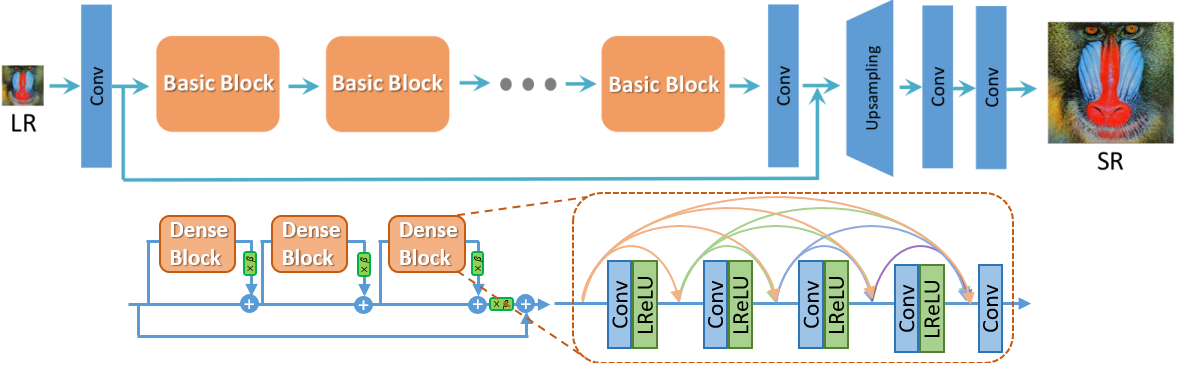

# Import librairies

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
import numpy as np
import os 

In [7]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  3


In [9]:
IMAGE_PATH = "images/mountain_lake_daytime.jpg"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [10]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [11]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

Exécution de la super résolution des images chargées à partir du chemin

In [12]:
hr_image = preprocess_image(IMAGE_PATH)

2024-05-23 10:03:52.536608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6723 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2024-05-23 10:03:52.537899: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1764 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0
2024-05-23 10:03:52.538961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14791 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


Saved as Original Image.jpg


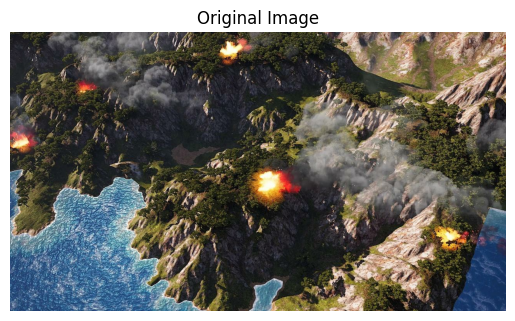

In [13]:
# Plotting Original Resolution image
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [14]:
model = hub.load(SAVED_MODEL_PATH)

In [15]:
start = time.time()
with tf.device('/CPU:0'): #On force avec CPU car en GPU ca fonctionne pas..
    fake_image = model(hr_image)
    fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

2024-05-23 10:04:48.913906: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1887436800 exceeds 10% of free system memory.
2024-05-23 10:04:48.914019: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4246732800 exceeds 10% of free system memory.
2024-05-23 10:04:50.450715: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1887436800 exceeds 10% of free system memory.


Time Taken: 18.237984


**fake_image = model(hr_image):**
Cette ligne applique le modele de super-résolution ou similaire à une image donnée hr_image. Le modèle est appelé avec hr_image comme entrée, et la sortie (générée par le modèle) est stockée dans la variable fake_image. Cela implique que fake_image contient l'image transformée ou améliorée produite par le modèle.

**fake_image = tf.squeeze(fake_image):**
Cette ligne utilise la fonction tf.squeeze() de TensorFlow pour supprimer toutes les dimensions de taille 1 de fake_image. Par exemple, si fake_image a une dimension supplémentaire avec taille 1 (comme [1, height, width, channels]), tf.squeeze() réduit cette dimension, simplifiant la forme du tenseur à [height, width, channels]. Cette étape est souvent nécessaire pour aligner les dimensions du tenseur pour d'autres opérations ou pour des raisons de visualisation/format de sortie.

Saved as Super Resolution.jpg


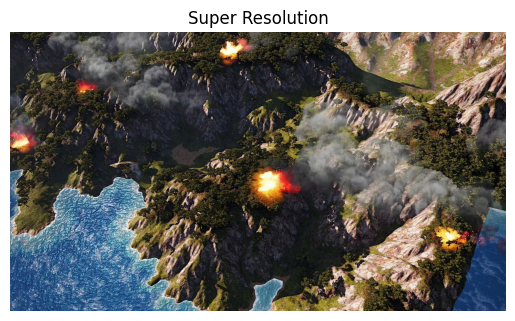

In [16]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

Evaluation de la perofrmance du modele

In [17]:
IMAGE_PATH2 = "images/mountain_lake_daytime_2800.jpg"

In [18]:
# Defining helper functions
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [19]:
hr_image = preprocess_image(IMAGE_PATH2)

In [20]:
lr_image = downscale_image(tf.squeeze(hr_image))

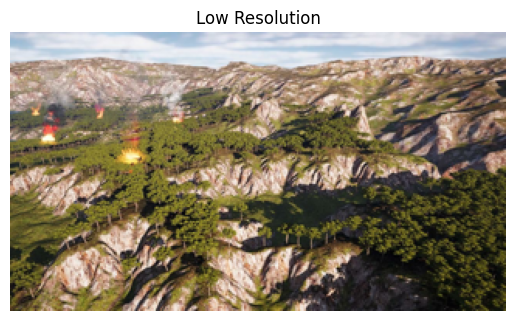

In [21]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), title="Low Resolution")

In [22]:
model = hub.load(SAVED_MODEL_PATH)

In [23]:
start = time.time()
with tf.device('/CPU:0'): #On recalcuol le temps
    fake_image = model(lr_image)
    fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 1.533381


It took less time to run

PSNR Achieved: 21.893005


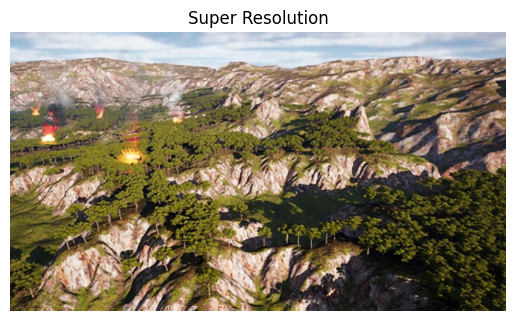

In [24]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

Comparer la taille des sorties côte à côte.

PSNR: 21.893005


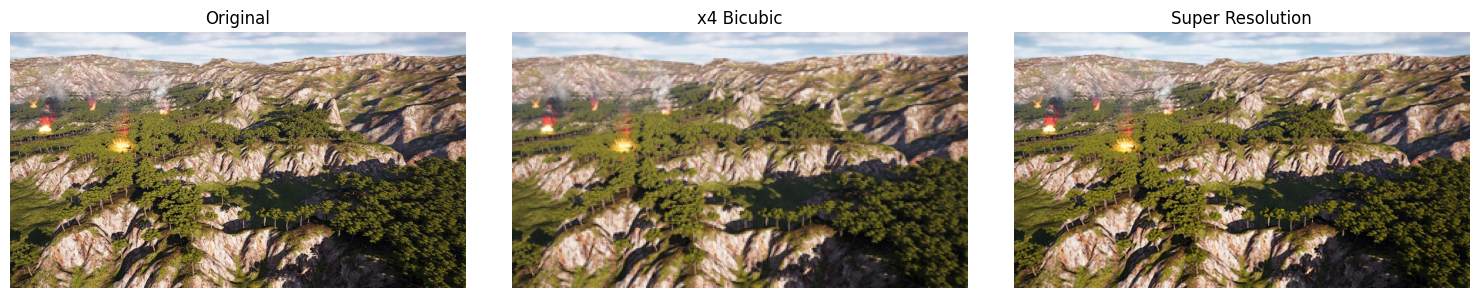

In [50]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 Bicubic")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)